In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import netCDF4
import cftime
from matplotlib.colors import LightSource
import matplotlib.patheffects as path_effects
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.mpl.ticker as cartopyticker
import rasterio
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
coast = cfeature.GSHHSFeature(scale="f")
plt.rcParams.update({'font.size': 18})

In [3]:
datadir = "../../data/Visible/"
figdir = "../../figures/"
bathyfile = "/data/GEBCO/gebco_2021_n46.0_s38.0_w0.0_e10.0.nc"
datafile = os.path.join(datadir, "2019-08-14-00 00_2019-08-14-23 59_Sentinel-3_OLCI_True_color2.tiff")

## Read data
### True Color

In [4]:
with rasterio.open(datafile) as r:
    truecolor = r.read()
    truecolor = np.transpose(truecolor, [1,2,0])
    bbox = r.bounds
    print(r.crs)

EPSG:4326


### Bathymetry & hillshading

In [5]:
with netCDF4.Dataset(bathyfile, 'r') as nc:
    lonb = nc.variables["lon"][:]
    latb = nc.variables["lat"][:]
    bathy = nc.variables["elevation"][:]
ls = LightSource(azdeg=315, altdeg=45)
cmap = plt.cm.gray
rgb = ls.shade(bathy, cmap=cmap, blend_mode="soft",
                    vert_exag=2, dx=lonb[1] - lonb[0], dy=latb[1]-latb[0])

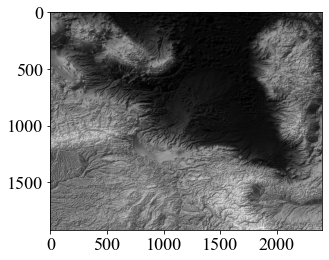

In [6]:
plt.imshow(rgb)

## Make plot

In [7]:
domain = [0., 12., 40., 45.]

In [8]:
theproj = ccrs.Mercator(central_longitude=0.5 * (domain[0] + domain[1]), 
                        min_latitude=domain[2], max_latitude=domain[3], 
                        latitude_true_scale=0.5 * (domain[2] + domain[3]))
datacrs = ccrs.PlateCarree()

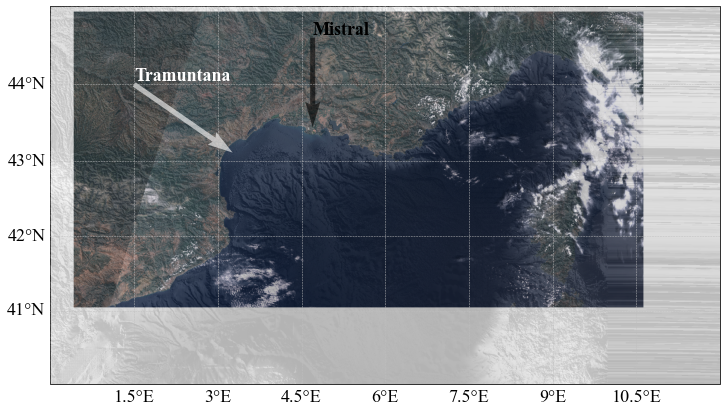

In [9]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=theproj)
ax.set_extent(domain)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.5, color='.75', alpha=0.95, linestyle='--', zorder=5)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

# Wind arrow and text
ax.text(1.5, 44., "Tramuntana", transform=datacrs, va="bottom", fontsize=18, 
        color="w", weight='bold', zorder=5)
ax.quiver(np.array([1.5]), np.array([44.]), np.array([4.]), np.array([-2]), 
          transform=datacrs, scale=25, alpha=.6, zorder=5, color="w")

ax.text(4.7, 44.6, "Mistral", transform=datacrs, va="bottom", fontsize=18, color="k", weight="bold",
        zorder=5)
ax.quiver(np.array([4.7]), np.array([44.6]), np.array([0]), np.array([-2]), 
          transform=datacrs, scale=15, alpha=.6, zorder=5)

# Other locations
ax.text(3.75, 43, "Gulf of\nLion", transform=datacrs, va="center", ha="center", fontsize=22)
ax.text(9., 42, "Corsica", transform=datacrs, va="center", ha="center", fontsize=22)


ax.imshow(truecolor, extent=[bbox.left, bbox.right, bbox.bottom, bbox.top], 
          transform=datacrs, zorder=3)
ax.imshow(rgb, extent=[lonb[0], lonb[-1], latb[0], latb[-1]], transform=datacrs, origin="lower",
         alpha=.3, zorder=4)

plt.show()

In [10]:
def scale_bar(ax, length=None, location=(0.5, 0.05), linewidth=3):
    """
    ax is the axes to draw the scalebar on.
    length is the length of the scalebar in km.
    location is center of the scalebar in axis coordinates.
    (ie. 0.5 is the middle of the plot)
    linewidth is the thickness of the scalebar.
    """
    #Get the limits of the axis in lat long
    llx0, llx1, lly0, lly1 = ax.get_extent(ccrs.PlateCarree())
    #Make tmc horizontally centred on the middle of the map,
    #vertically at scale bar location
    sbllx = (llx1 + llx0) / 2
    sblly = lly0 + (lly1 - lly0) * location[1]
    tmc = ccrs.TransverseMercator(sbllx, sblly)
    #Get the extent of the plotted area in coordinates in metres
    x0, x1, y0, y1 = ax.get_extent(tmc)
    #Turn the specified scalebar location into coordinates in metres
    sbx = x0 + (x1 - x0) * location[0]
    sby = y0 + (y1 - y0) * location[1]

    #Calculate a scale bar length if none has been given
    #(Theres probably a more pythonic way of rounding the number but this works)
    if not length: 
        length = (x1 - x0) / 5000 #in km
        ndim = int(np.floor(np.log10(length))) #number of digits in number
        length = round(length, -ndim) #round to 1sf
        #Returns numbers starting with the list
        def scale_number(x):
            if str(x)[0] in ['1', '2', '5']: return int(x)        
            else: return scale_number(x - 10 ** ndim)
        length = scale_number(length) 

    #Generate the x coordinate for the ends of the scalebar
    bar_xs = [sbx - length * 500, sbx + length * 500]
    #Plot the scalebar
    ax.plot(bar_xs, [sby, sby], transform=tmc, color='k', linewidth=linewidth)
    #Plot the scalebar label
    ax.text(sbx, sby, str(length) + ' km', transform=tmc,
            horizontalalignment='center', verticalalignment='bottom')

In [29]:
fig = plt.figure(figsize=(12, 8))
ax = plt.subplot(111, projection=theproj)
ax.set_extent(domain)

# Wind arrow and text
ax.text(1.2, 43.75, "Tramuntana", transform=datacrs, va="bottom", fontsize=18, 
        color="k", weight='bold')
ax.quiver(np.array([1.2]), np.array([43.75]), np.array([4.]), np.array([-1.5]), 
          transform=datacrs, scale=25, alpha=.6)

ax.text(4.7, 44.6, "Mistral", transform=datacrs, va="bottom", fontsize=18, color="k", weight="bold")
ax.quiver(np.array([4.7]), np.array([44.6]), np.array([0]), np.array([-2]), 
          transform=datacrs, scale=15, alpha=.6)

# Other locations
ax.text(3.85, 42.9, "Gulf of\nLion", transform=datacrs, va="center", ha="center", fontsize=22)
ax.text(9., 42, "Corsica", transform=datacrs, va="center", ha="center", fontsize=22)
ax.text(9.1, 40.5, "Sardinia", transform=datacrs, va="center", ha="center", fontsize=22)
ax.text(9.8, 41.3, "Strait of Bonifacio", transform=datacrs, va="center", ha="center", fontsize=20)

gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=.75, color='.5', alpha=0.95, linestyle='--', zorder=2)
gl.top_labels = False
gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER

ax.add_wms(wms='http://ows.emodnet-bathymetry.eu/wms',
           layers=['emodnet:mean_atlas_land'])

ax.add_feature(cartopy.feature.BORDERS, linestyle=':', alpha=1, lw=1.5)
scale_bar(ax, 100)
plt.savefig(os.path.join(figdir, "map_winds_V4.jpg"), dpi=300, bbox_inches="tight")
plt.close()

<ipython-input-10-0061ef7a04fb>:15: UserWarning: The default value for the *approx* keyword argument to TransverseMercator will change from True to False after 0.18.
  tmc = ccrs.TransverseMercator(sbllx, sblly)
